# Wind Energy Production

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer, r2_score, mean_absolute_error,mean_absolute_percentage_error
import joblib
from sklearn.pipeline import Pipeline
from joblib import dump

## Load and Check Data

In [62]:
production_data = pd.read_csv("production_data.csv")
weather_parameters = pd.read_csv("weather_parameters.csv", low_memory=False)

In [63]:
production_data.head()

,date,power_production
0,2021-01-01 00:00:00.000000 UTC,34.0
1,2021-01-01 01:00:00.000000 UTC,43.0
2,2021-01-01 02:00:00.000000 UTC,53.0
3,2021-01-01 03:00:00.000000 UTC,42.0
4,2021-01-01 04:00:00.000000 UTC,38.0


In [64]:
weather_parameters.head()

,date,sicaklik,U10,V10,ruzgarhizi,ruzgaryonu,Basinc,Gelen_Gunes,Q2,SoilTemp,...,seviye4_U_V_W_ruzgar_hizi_destagger,seviye5_U_destagger,seviye5_V_destagger,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,input_model,grid
0,2021-01-01 00:00:00+00:00,284.6445,-1.9608619,0.70651054,2.0842593,109.8144,99275.54,0.0,0.008035007,281.47678,...,6.2419105,-1.5867202,7.1662884,0.06714442,7.339848,7.340155,0.22032219,1.20327269618442,ecmwf,alt
1,2021-01-01 00:10:00+00:00,284.6286,-1.9545457,NaN,2.0801475,110.01237,99276.0,0.0,0.008026625,281.45035,...,6.243813,-1.5645404,7.1722765,0.0667035,7.3409357,7.341239,0.22001477,1.20335770484416,ecmwf,alt
2,2021-01-01 00:20:00+00:00,284.60474,-1.9748324,0.70805645,2.0979292,109.724785,99282.18,0.0,0.0080173,281.42465,...,6.248305,-1.5730217,7.1681805,0.065751836,NaN,7.3390417,0.22130074,1.20354710286607,ecmwf,alt
3,2021-01-01 00:30:00+00:00,284.57266,-1.9904897,0.7020336,2.1106634,109.42744,99282.41,0.0,0.008000456,281.40067,...,6.2467284,-1.5731285,7.16255,0.065337256,7.33327,7.3335614,0.2217745,1.20371003546932,ecmwf,alt
4,2021-01-01 00:40:00+00:00,284.55075,-2.0001407,0.70004934,2.119111,109.29005,99284.36,0.0,0.007984767,281.37738,...,6.2465825,-1.5701456,7.1608706,0.06489058,7.330991,7.3312783,0.22220805,1.20384926361222,ecmwf,alt


### Date-Time Strings

In [65]:
production_data['date'] = production_data['date'].str.rstrip(" UTC")

In [66]:
production_data['date'] = pd.to_datetime(production_data['date'].str.replace(r'\.\d+', ''), errors='coerce')

In [67]:
production_data['date'] = pd.to_datetime(production_data['date']).dt.tz_localize('UTC')


In [68]:
weather_parameters.head(10)

,date,sicaklik,U10,V10,ruzgarhizi,ruzgaryonu,Basinc,Gelen_Gunes,Q2,SoilTemp,...,seviye4_U_V_W_ruzgar_hizi_destagger,seviye5_U_destagger,seviye5_V_destagger,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,input_model,grid
0,2021-01-01 00:00:00+00:00,284.6445,-1.9608619,0.70651054,2.0842593,109.8144,99275.54,0.0,0.008035007,281.47678,...,6.2419105,-1.5867202,7.1662884,0.06714442,7.339848,7.340155,0.22032219,1.20327269618442,ecmwf,alt
1,2021-01-01 00:10:00+00:00,284.6286,-1.9545457,NaN,2.0801475,110.01237,99276.0,0.0,0.008026625,281.45035,...,6.243813,-1.5645404,7.1722765,0.0667035,7.3409357,7.341239,0.22001477,1.20335770484416,ecmwf,alt
2,2021-01-01 00:20:00+00:00,284.60474,-1.9748324,0.70805645,2.0979292,109.724785,99282.18,0.0,0.0080173,281.42465,...,6.248305,-1.5730217,7.1681805,0.065751836,NaN,7.3390417,0.22130074,1.20354710286607,ecmwf,alt
3,2021-01-01 00:30:00+00:00,284.57266,-1.9904897,0.7020336,2.1106634,109.42744,99282.41,0.0,0.008000456,281.40067,...,6.2467284,-1.5731285,7.16255,0.065337256,7.33327,7.3335614,0.2217745,1.20371003546932,ecmwf,alt
4,2021-01-01 00:40:00+00:00,284.55075,-2.0001407,0.70004934,2.119111,109.29005,99284.36,0.0,0.007984767,281.37738,...,6.2465825,-1.5701456,7.1608706,0.06489058,7.330991,7.3312783,0.22220805,1.20384926361222,ecmwf,alt
5,2021-01-01 00:50:00+00:00,284.5207,-2.0116174,0.70119804,2.1303246,109.21724,99288.195,0.0,0.00796489,281.3556,...,6.257503,-1.5921597,7.1621733,0.064179674,7.337009,7.33729,0.22263356,1.20405192846332,ecmwf,alt
6,2021-01-01 01:00:00+00:00,284.49362,-2.0174422,0.7020506,2.1361058,109.18741,99291.0,0.0,0.007945825,281.33487,...,6.262579,-1.5957074,7.1658053,0.06366344,7.341325,7.341601,0.22273582,1.20422829033797,ecmwf,alt
7,2021-01-01 01:10:00+00:00,284.4694,-2.0280874,0.7048751,2.147088,109.16523,99296.22,0.0,0.007926449,281.3147,...,6.2725973,-1.6178564,7.167404,0.063077375,7.34773,7.348001,0.22341384,1.2044224069978,ecmwf,alt
8,2021-01-01 01:20:00+00:00,284.44897,-2.034206,0.7077598,2.1538146,109.18428,99299.664,0.0,0.007909382,281.29507,...,6.2681766,-1.6077887,7.1678586,0.062513135,7.3459635,7.3462296,0.22382957,1.20457552707085,ecmwf,alt
9,2021-01-01 01:30:00+00:00,284.4147,-2.0497987,0.7097969,2.1692133,109.09976,99303.98,0.0,0.00788655,281.27704,...,6.285773,-1.6502821,7.1690264,0.061659463,7.3565187,7.356777,0.224539,1.20480628398145,ecmwf,alt


In [69]:
production_data.head(10)

,date,power_production
0,2021-01-01 00:00:00+00:00,34.0
1,2021-01-01 01:00:00+00:00,43.0
2,2021-01-01 02:00:00+00:00,53.0
3,2021-01-01 03:00:00+00:00,42.0
4,2021-01-01 04:00:00+00:00,38.0
5,2021-01-01 05:00:00+00:00,46.0
6,2021-01-01 06:00:00+00:00,43.0
7,2021-01-01 07:00:00+00:00,30.0
8,2021-01-01 08:00:00+00:00,32.0
9,2021-01-01 09:00:00+00:00,21.0


In [70]:
weather_parameters['date'] = pd.to_datetime(weather_parameters['date'], errors='coerce')
production_data['date'] = pd.to_datetime(production_data['date'], errors='coerce')

In [71]:
# veriyi date column'a göre birleştirdim.
data = pd.merge(weather_parameters, production_data, on='date', how='left')

In [72]:
data.head(50)

,date,sicaklik,U10,V10,ruzgarhizi,ruzgaryonu,Basinc,Gelen_Gunes,Q2,SoilTemp,...,seviye5_U_destagger,seviye5_V_destagger,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,input_model,grid,power_production
0,2021-01-01 00:00:00+00:00,284.6445,-1.9608619,0.70651054,2.0842593,109.8144,99275.54,0.0,0.008035007,281.47678,...,-1.5867202,7.1662884,0.06714442,7.339848,7.340155,0.22032219,1.20327269618442,ecmwf,alt,34.0
1,2021-01-01 00:10:00+00:00,284.6286,-1.9545457,NaN,2.0801475,110.01237,99276.0,0.0,0.008026625,281.45035,...,-1.5645404,7.1722765,0.0667035,7.3409357,7.341239,0.22001477,1.20335770484416,ecmwf,alt,NaN
2,2021-01-01 00:20:00+00:00,284.60474,-1.9748324,0.70805645,2.0979292,109.724785,99282.18,0.0,0.0080173,281.42465,...,-1.5730217,7.1681805,0.065751836,NaN,7.3390417,0.22130074,1.20354710286607,ecmwf,alt,NaN
3,2021-01-01 00:30:00+00:00,284.57266,-1.9904897,0.7020336,2.1106634,109.42744,99282.41,0.0,0.008000456,281.40067,...,-1.5731285,7.16255,0.065337256,7.33327,7.3335614,0.2217745,1.20371003546932,ecmwf,alt,NaN
4,2021-01-01 00:40:00+00:00,284.55075,-2.0001407,0.70004934,2.119111,109.29005,99284.36,0.0,0.007984767,281.37738,...,-1.5701456,7.1608706,0.06489058,7.330991,7.3312783,0.22220805,1.20384926361222,ecmwf,alt,NaN
5,2021-01-01 00:50:00+00:00,284.5207,-2.0116174,0.70119804,2.1303246,109.21724,99288.195,0.0,0.00796489,281.3556,...,-1.5921597,7.1621733,0.064179674,7.337009,7.33729,0.22263356,1.20405192846332,ecmwf,alt,NaN
6,2021-01-01 01:00:00+00:00,284.49362,-2.0174422,0.7020506,2.1361058,109.18741,99291.0,0.0,0.007945825,281.33487,...,-1.5957074,7.1658053,0.06366344,7.341325,7.341601,0.22273582,1.20422829033797,ecmwf,alt,43.0
7,2021-01-01 01:10:00+00:00,284.4694,-2.0280874,0.7048751,2.147088,109.16523,99296.22,0.0,0.007926449,281.3147,...,-1.6178564,7.167404,0.063077375,7.34773,7.348001,0.22341384,1.2044224069978,ecmwf,alt,NaN
8,2021-01-01 01:20:00+00:00,284.44897,-2.034206,0.7077598,2.1538146,109.18428,99299.664,0.0,0.007909382,281.29507,...,-1.6077887,7.1678586,0.062513135,7.3459635,7.3462296,0.22382957,1.20457552707085,ecmwf,alt,NaN
9,2021-01-01 01:30:00+00:00,284.4147,-2.0497987,0.7097969,2.1692133,109.09976,99303.98,0.0,0.00788655,281.27704,...,-1.6502821,7.1690264,0.061659463,7.3565187,7.356777,0.224539,1.20480628398145,ecmwf,alt,NaN


## Preprocessing

In [73]:
# Rüzgar hızı ve yönünü kullanarak yeni özellikler türettim
data['ruzgaryonu'] = pd.to_numeric(data['ruzgaryonu'], errors='coerce')
data['ruzgarhizi'] = pd.to_numeric(data['ruzgarhizi'], errors='coerce')
data['Wind_X'] = data['ruzgarhizi'] * np.cos(np.radians(data['ruzgaryonu']))
data['Wind_Y'] = data['ruzgarhizi'] * np.sin(np.radians(data['ruzgaryonu']))

In [74]:
data.drop(['input_model', 'grid','ruzgarhizi','ruzgaryonu'], axis=1, inplace=True)

### Find and Fill Missing Value

In [75]:
data.columns[data.isnull().any()]

Index(['date', 'sicaklik', 'U10', 'V10', 'Basinc', 'Gelen_Gunes', 'Q2',
       'SoilTemp', 'Ground_heat_flux', 'TKE', 'Down_Long', 'Out_Long',
       'NOAHRES', 'Upward_Heat', 'Upward_mois', 'Latent_Heat', 'PBLheight',
       '81m_U', '81m_V', '81m_W', '81m_U_V_ruzgar_hizi',
       '81m_U_V_W_ruzgar_hizi', '140m_U', '140m_V', '140m_W',
       '140m_U_V_ruzgar_hizi', '140m_U_V_W_ruzgar_hizi', 'seviye3_U',
       'seviye3_V', 'seviye3_W', 'seviye3_U_V_ruzgar_hizi',
       'seviye3_U_V_W_ruzgar_hizi', 'seviye4_U', 'seviye4_V', 'seviye4_W',
       'seviye4_U_V_ruzgar_hizi', 'seviye4_U_V_W_ruzgar_hizi', 'seviye5_U',
       'seviye5_V', 'seviye5_W', 'seviye5_U_V_ruzgar_hizi',
       'seviye5_U_V_W_ruzgar_hizi', '81m_U_destagger', '81m_V_destagger',
       '81m_W_destagger', '81m_U_V_ruzgar_hizi_destagger',
       '81m_U_V_W_ruzgar_hizi_destagger', '140m_U_destagger',
       '140m_V_destagger', '140m_W_destagger',
       '140m_U_V_ruzgar_hizi_destagger', '140m_U_V_W_ruzgar_hizi_destagger',
  

In [76]:
data.isnull().sum()

date                  7349
sicaklik              7401
U10                   7339
V10                   7251
Basinc                7302
                     ...  
monin_obukhov         7384
Hava_yogunlugu        7448
power_production    763861
Wind_X               14488
Wind_Y               14488
Length: 72, dtype: int64

In [77]:
data[data["date"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_U_destagger,seviye5_V_destagger,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y
129,NaT,284.67892,-2.2232134,-0.73853403,99580.07,0.0,0.007175884,283.40497,29.057095,0.10003077,...,-2.3522248,4.6359935,0.0377286,5.198596,5.198733,0.2318723,1.20807343417555,NaN,0.738534,2.223213
186,NaT,286.9464,-2.2125418,-1.6289475,99707.05,290.69666,0.00724169,282.84314,-71.74736,0.23737775,...,-2.0714355,2.7016935,0.025534566,3.4044077,3.4045036,0.39145645,1.19995974686431,NaN,1.628948,2.212542
391,NaT,286.97116,-1.0017743,-1.4812682,99612.4,0.0,0.007366586,285.70898,NaN,0.10000001,...,-0.92409265,0.9906628,0.04302936,1.3547546,1.3554378,0.16092959,1.19853604001406,NaN,1.481268,1.001774
563,NaT,287.44812,-2.9629889,4.422932,99076.96,0.0,0.009214376,286.31927,4.2440124,0.7456554,...,-5.7503614,14.26044,0.12857872,15.376176,15.376714,0.673699,1.18745792819433,NaN,-4.422932,2.962989
622,NaT,289.8031,1.1974384,0.84062415,99233.88,530.29193,0.0085067665,288.4546,-77.792,0.48624024,...,2.1621392,1.1712606,0.022592343,2.4590032,2.459107,0.3580985,1.18068398470629,NaN,-0.840624,-1.197438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914707,NaT,281.01288,0.1872315,2.6127477,92524.17,50.874226,0.0056454516,279.4776,7.7850885,0.112086505,...,0.68739355,6.279784,-0.013945422,6.3172936,6.317309,0.26810306,1.13922705974029,NaN,-2.612748,-0.187231
914754,NaT,278.69495,-1.3162493,2.2183647,92434.64,0.0,0.0057135066,278.41772,12.169304,0.13839047,...,-0.22475603,5.44878,-0.023138262,5.4534135,5.4534626,0.2736652,1.14749593601077,NaN,-2.218365,1.316249
914763,NaT,278.56586,-1.371549,2.231757,92400.72,0.0,0.0057560652,278.13196,9.527021,0.14788803,...,-0.41274348,5.208249,-0.008938719,5.224578,5.2245855,0.28238085,1.14754720553444,NaN,-2.231757,1.371549
914872,NaT,277.6143,-1.8367952,2.3103878,92013.78,0.0,0.005296319,278.89935,27.447899,0.23355296,...,-2.9898763,8.575862,-0.03376281,9.082112,9.082175,0.32645258,1.14729774172744,NaN,-2.310388,1.836795


In [78]:
# 'date' sütunundaki NaN değerleri bir önceki verideki 'date' sütununu baz alarak doldurdum
data['date'] = pd.to_datetime(data['date'], errors='coerce')
for i in range(1, len(data)):
    if pd.isnull(data.loc[i, 'date']):
        data.loc[i, 'date'] = data.loc[i-1, 'date'] + pd.to_timedelta('10 minutes')

In [79]:
data[data["date"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_U_destagger,seviye5_V_destagger,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y


In [80]:
data[data["sicaklik"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_U_destagger,seviye5_V_destagger,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y
133,2021-01-01 22:20:00+00:00,NaN,-2.227805,-0.8505937,99591.25,0.0,0.0070734876,283.17017,27.651245,0.1000358,...,-2.3114066,4.59291,NaN,5.141733,5.141876,0.23672797,1.20878129740584,NaN,0.850594,2.227805
235,2021-01-02 15:50:00+00:00,NaN,-0.2564923,1.4408346,99659.86,0.0,0.007922013,287.49744,62.36088,0.1,...,-0.725325,1.1771369,0.0030328645,1.3826596,1.3826629,0.0883605,1.19552824786921,NaN,-1.440835,0.256492
261,2021-01-02 20:10:00+00:00,NaN,-1.546486,-1.4578509,99708.62,0.0,0.0076107513,284.0041,40.5201,0.10002361,...,-1.7604065,1.6396518,0.048433922,2.40572,2.4062076,0.22501017,1.2028197094316,NaN,1.457851,1.546486
276,2021-01-02 23:00:00+00:00,NaN,-1.9491284,-1.9369284,99726.01,0.0,0.0070881695,282.9888,22.642344,0.10009391,...,-1.1074537,3.1139934,0.03218799,3.305058,3.3052146,0.28274512,1.21143754333064,3.79,1.936928,1.949128
297,2021-01-03 02:30:00+00:00,NaN,-2.08972,-2.0688446,99730.07,0.0,0.0067016296,282.36472,19.139925,0.100137495,...,-0.7065059,3.46796,0.02585296,3.5391943,3.5392888,0.3087751,1.21382719538058,NaN,2.068845,2.089720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914888,2021-12-28 21:10:00+00:00,NaN,-2.2187405,2.107809,91969.555,0.0,0.005170821,277.98752,21.778635,0.27679497,...,-3.1549256,8.767725,-0.03279387,9.318077,9.318134,0.34191436,1.14802563102947,NaN,-2.107809,2.218740
914976,2021-12-29 12:30:00+00:00,NaN,-2.7221968,3.9444075,91633.49,255.13014,0.0061023915,280.4127,-15.003308,0.7101138,...,-5.014863,8.216778,-0.049530182,9.626229,9.626356,0.6648255,1.12855577262626,NaN,-3.944407,2.722197
915045,2021-12-30 00:10:00+00:00,NaN,-1.9654859,1.8410373,91346.85,0.0,0.006038474,278.71008,5.2451935,0.2248337,...,-4.6917124,8.324827,-0.040751867,9.555883,9.55597,0.31437883,1.13221772867099,NaN,-1.841037,1.965486
915068,2021-12-30 04:00:00+00:00,NaN,-1.3957756,0.062309638,91273.4,0.0,0.0058603445,278.4813,9.403448,0.1,...,-4.4846935,3.4017234,-0.01939549,5.628872,5.6289053,0.12379071,1.13276689522369,31.40,-0.062310,1.395776


In [81]:
# 'date'deki aylara göre 'season' column'u oluşturdum. Mevsimlere göre değişkenlik gösterebilecek sütunları bu duruma göre doldurdum.
data['month'] = data['date'].dt.month

In [82]:
data['season'] = data['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Autumn' if x in [9, 10, 11] else None)

In [83]:
data['sicaklik'] = pd.to_numeric(data['sicaklik'], errors='coerce')

In [84]:
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['sicaklik'].notna())]['sicaklik'].mean()
    data.loc[data['season'] == season, 'sicaklik'] = data.loc[data['season'] == season, 'sicaklik'].fillna(season_avg_temp)

In [85]:
data[data["sicaklik"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [86]:
data['U10'] = pd.to_numeric(data['U10'], errors='coerce')

filtered_data = data[(data['U10'] < 100) & (data['U10'] > -100)]
mean_of_outliers = filtered_data['U10'].mean()
print("U10 sütunundaki 100'den küçük veya -100'den büyük değerlerin ortalaması:", mean_of_outliers)
nan_values = data['U10'].isna()
data.loc[nan_values, 'U10'] = mean_of_outliers

U10 sütunundaki 100'den küçük veya -100'den büyük değerlerin ortalaması: -0.3595379744482286


In [87]:
data[data["U10"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [88]:
data['V10'] = pd.to_numeric(data['V10'], errors='coerce')

filtered_data = data[(data['V10'] < 100) & (data['V10'] > -100)]
mean_of_outliers = filtered_data['V10'].mean()
print("V10 sütunundaki 100'den küçük veya -100'den büyük değerlerin ortalaması:", mean_of_outliers)
nan_values = data['V10'].isna()
data.loc[nan_values, 'V10'] = mean_of_outliers

V10 sütunundaki 100'den küçük veya -100'den büyük değerlerin ortalaması: -0.5417154783036761


In [89]:
data[data["V10"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [90]:
data['Wind_X'] = pd.to_numeric(data['Wind_X'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Wind_X'].notna())]['Wind_X'].mean()
    data.loc[data['season'] == season, 'Wind_X'] = data.loc[data['season'] == season, 'Wind_X'].fillna(season_avg_temp)

In [91]:
data[data["Wind_X"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [92]:
data['Wind_Y'] = pd.to_numeric(data['Wind_Y'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Wind_Y'].notna())]['Wind_Y'].mean()
    data.loc[data['season'] == season, 'Wind_Y'] = data.loc[data['season'] == season, 'Wind_Y'].fillna(season_avg_temp)

In [93]:
data[data["Wind_Y"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [94]:
data['Gelen_Gunes'] = pd.to_numeric(data['Gelen_Gunes'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Gelen_Gunes'].notna())]['Gelen_Gunes'].mean()
    data.loc[data['season'] == season, 'Gelen_Gunes'] = data.loc[data['season'] == season, 'Gelen_Gunes'].fillna(season_avg_temp)

In [95]:
data[data["Gelen_Gunes"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [96]:
data['SoilTemp'] = pd.to_numeric(data['SoilTemp'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['SoilTemp'].notna())]['SoilTemp'].mean()
    data.loc[data['season'] == season, 'SoilTemp'] = data.loc[data['season'] == season, 'SoilTemp'].fillna(season_avg_temp)

In [97]:
data[data["SoilTemp"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [98]:
data['Ground_heat_flux'] = pd.to_numeric(data['Ground_heat_flux'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Ground_heat_flux'].notna())]['Ground_heat_flux'].mean()
    data.loc[data['season'] == season, 'Ground_heat_flux'] = data.loc[data['season'] == season, 'Ground_heat_flux'].fillna(season_avg_temp)

In [99]:
data[data["Ground_heat_flux"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [100]:
data['TKE'] = pd.to_numeric(data['TKE'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['TKE'].notna())]['TKE'].mean()
    data.loc[data['season'] == season, 'TKE'] = data.loc[data['season'] == season, 'TKE'].fillna(season_avg_temp)

In [101]:
data[data["TKE"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [102]:
data['Upward_Heat'] = pd.to_numeric(data['Upward_Heat'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Upward_Heat'].notna())]['Upward_Heat'].mean()
    data.loc[data['season'] == season, 'Upward_Heat'] = data.loc[data['season'] == season, 'Upward_Heat'].fillna(season_avg_temp)

In [103]:
data[data["Upward_Heat"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [104]:
data['Upward_mois'] = pd.to_numeric(data['Upward_mois'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Upward_mois'].notna())]['Upward_mois'].mean()
    data.loc[data['season'] == season, 'Upward_mois'] = data.loc[data['season'] == season, 'Upward_mois'].fillna(season_avg_temp)

In [105]:
data[data["Upward_Heat"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [106]:
data['Latent_Heat'] = pd.to_numeric(data['Latent_Heat'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Latent_Heat'].notna())]['Latent_Heat'].mean()
    data.loc[data['season'] == season, 'Latent_Heat'] = data.loc[data['season'] == season, 'Latent_Heat'].fillna(season_avg_temp)

In [107]:
data[data["Latent_Heat"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [108]:
data['PBLheight'] = pd.to_numeric(data['PBLheight'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['PBLheight'].notna())]['PBLheight'].mean()
    data.loc[data['season'] == season, 'PBLheight'] = data.loc[data['season'] == season, 'PBLheight'].fillna(season_avg_temp)

In [109]:
data[data["PBLheight"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [110]:
data['monin_obukhov'] = pd.to_numeric(data['monin_obukhov'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['monin_obukhov'].notna())]['monin_obukhov'].mean()
    data.loc[data['season'] == season, 'monin_obukhov'] = data.loc[data['season'] == season, 'monin_obukhov'].fillna(season_avg_temp)

In [111]:
data[data["monin_obukhov"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [112]:
data['Hava_yogunlugu'] = pd.to_numeric(data['Hava_yogunlugu'], errors='coerce')
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for season in seasons:
    season_avg_temp = data[(data['season'] == season) & (data['Hava_yogunlugu'].notna())]['Hava_yogunlugu'].mean()
    data.loc[data['season'] == season, 'Hava_yogunlugu'] = data.loc[data['season'] == season, 'Hava_yogunlugu'].fillna(season_avg_temp)

In [113]:
data[data["Hava_yogunlugu"].isnull()]

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season


In [114]:
columns = ['Basinc', 'Q2', 'Down_Long', 'Out_Long', 'NOAHRES', '81m_U', '81m_V',
       '81m_W', '81m_U_V_ruzgar_hizi', '81m_U_V_W_ruzgar_hizi', '140m_U',
       '140m_V', '140m_W', '140m_U_V_ruzgar_hizi', '140m_U_V_W_ruzgar_hizi',
       'seviye3_U', 'seviye3_V', 'seviye3_W', 'seviye3_U_V_ruzgar_hizi',
       'seviye3_U_V_W_ruzgar_hizi', 'seviye4_U', 'seviye4_V', 'seviye4_W',
       'seviye4_U_V_ruzgar_hizi', 'seviye4_U_V_W_ruzgar_hizi', 'seviye5_U',
       'seviye5_V', 'seviye5_W', 'seviye5_U_V_ruzgar_hizi',
       'seviye5_U_V_W_ruzgar_hizi', '81m_U_destagger', '81m_V_destagger',
       '81m_W_destagger', '81m_U_V_ruzgar_hizi_destagger',
       '81m_U_V_W_ruzgar_hizi_destagger', '140m_U_destagger',
       '140m_V_destagger', '140m_W_destagger',
       '140m_U_V_ruzgar_hizi_destagger', '140m_U_V_W_ruzgar_hizi_destagger',
       'seviye3_U_destagger', 'seviye3_V_destagger', 'seviye3_W_destagger',
       'seviye3_U_V_ruzgar_hizi_destagger',
       'seviye3_U_V_W_ruzgar_hizi_destagger', 'seviye4_U_destagger',
       'seviye4_V_destagger', 'seviye4_W_destagger',
       'seviye4_U_V_ruzgar_hizi_destagger',
       'seviye4_U_V_W_ruzgar_hizi_destagger', 'seviye5_U_destagger',
       'seviye5_V_destagger', 'seviye5_W_destagger',
       'seviye5_U_V_ruzgar_hizi_destagger',
       'seviye5_U_V_W_ruzgar_hizi_destagger']

for column in columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
    column_mean = data[column].mean()
    data[column] = data[column].fillna(column_mean)

In [115]:
data.columns[data.isnull().any()]

Index(['power_production'], dtype='object')

In [116]:
data_model = data[data['power_production'].notna()]

In [117]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151323 entries, 0 to 915178
Data columns (total 74 columns):
 #   Column                               Non-Null Count   Dtype              
---  ------                               --------------   -----              
 0   date                                 151323 non-null  datetime64[ns, UTC]
 1   sicaklik                             151323 non-null  float64            
 2   U10                                  151323 non-null  float64            
 3   V10                                  151323 non-null  float64            
 4   Basinc                               151323 non-null  float64            
 5   Gelen_Gunes                          151323 non-null  float64            
 6   Q2                                   151323 non-null  float64            
 7   SoilTemp                             151323 non-null  float64            
 8   Ground_heat_flux                     151323 non-null  float64            
 9   TKE                 

In [118]:
data_model.head(50)

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season
0,2021-01-01 00:00:00+00:00,284.644500,-1.960862,0.706511,99275.540,0.000000,0.008035,281.47678,20.936728,0.100020,...,0.067144,7.339848,7.340155,0.220322,1.203273,34.00,-0.706511,1.960862,1,Winter
6,2021-01-01 01:00:00+00:00,284.493620,-2.017442,0.702051,99291.000,0.000000,0.007946,281.33487,18.601260,0.100022,...,0.063663,7.341325,7.341601,0.222736,1.204228,43.00,-0.702051,2.017442,1,Winter
12,2021-01-01 02:00:00+00:00,284.318630,-2.077648,0.727540,99314.790,0.000000,0.007818,281.22913,16.295807,0.100025,...,0.060172,7.378341,7.378586,0.225882,1.205444,53.00,-0.727540,2.077648,1,Winter
18,2021-01-01 03:00:00+00:00,284.125100,-2.129894,0.769820,99335.380,0.000000,0.007687,281.15765,14.212908,0.100028,...,0.058527,7.430159,7.430389,0.229056,1.206708,42.00,-0.769820,2.129894,1,Winter
24,2021-01-01 04:00:00+00:00,283.931340,-2.175473,0.820330,99357.090,0.000000,0.007562,281.11660,12.416360,0.100032,...,0.057575,7.469202,7.469423,0.232791,1.207977,38.00,-0.820330,2.175473,1,Winter
30,2021-01-01 05:00:00+00:00,283.759900,-2.231888,0.797581,99380.900,0.000000,-15910.021717,281.08870,12.160687,0.100036,...,0.053663,7.378065,7.378260,0.236412,1.209164,46.00,-0.797580,2.231888,1,Winter
36,2021-01-01 06:00:00+00:00,283.748170,-2.311091,0.785464,99401.630,42.137295,0.007534,281.21140,-11.552200,0.100051,...,0.048834,7.251439,7.251603,0.250379,1.209339,43.00,-0.785464,2.311091,1,Winter
42,2021-01-01 07:00:00+00:00,285.771580,-2.393755,0.949301,99404.600,208.037770,0.008292,282.03705,-62.505245,0.167425,...,0.042608,7.136729,7.136856,0.352347,1.199712,30.00,-0.949301,2.393755,1,Winter
48,2021-01-01 08:00:00+00:00,287.381960,-2.322446,1.443922,99390.945,358.818020,0.008628,283.27457,-88.259690,0.292799,...,0.034956,6.816594,6.816683,0.420364,1.192340,32.00,-1.443922,2.322446,1,Winter
54,2021-01-01 09:00:00+00:00,288.237240,-1.970494,1.859411,99380.830,467.073600,0.008726,284.63614,-96.580100,0.340604,...,0.030125,6.545605,6.545675,0.444750,1.188541,21.00,-1.859411,1.970494,1,Winter


### Outlier Detection

In [154]:
def remove_outliers(data, columns):
    cleaned_data = data.copy()
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75) 
        IQR = Q3 - Q1
        upper = Q3 + 1.5 * IQR
        lower = Q1 - 1.5 * IQR
        cleaned_data = cleaned_data[(cleaned_data[column] >= lower) & (cleaned_data[column] <= upper)]
 # Sadece temizlenmiş verileri al
    return cleaned_data

In [155]:
cleaned_data = remove_outliers(data_model, ["U10", "V10", "sicaklik", "Basinc", "Gelen_Gunes", "Q2", "Wind_X", "Wind_Y", "SoilTemp", "Ground_heat_flux", "TKE", "Down_Long", "Out_Long", "Upward_Heat", "Upward_mois", "NOAHRES", "monin_obukhov", "PBLheight", "Latent_Heat", "Hava_yogunlugu"])

In [156]:
cleaned_data.shape

(95830, 74)

In [159]:
cleaned_data.head()

,date,sicaklik,U10,V10,Basinc,Gelen_Gunes,Q2,SoilTemp,Ground_heat_flux,TKE,...,seviye5_W_destagger,seviye5_U_V_ruzgar_hizi_destagger,seviye5_U_V_W_ruzgar_hizi_destagger,monin_obukhov,Hava_yogunlugu,power_production,Wind_X,Wind_Y,month,season
0,2021-01-01 00:00:00+00:00,284.64450,-1.960862,0.706511,99275.54,0.0,0.008035,281.47678,20.936728,0.100020,...,0.067144,7.339848,7.340155,0.220322,1.203273,34.0,-0.706511,1.960862,1,Winter
6,2021-01-01 01:00:00+00:00,284.49362,-2.017442,0.702051,99291.00,0.0,0.007946,281.33487,18.601260,0.100022,...,0.063663,7.341325,7.341601,0.222736,1.204228,43.0,-0.702051,2.017442,1,Winter
12,2021-01-01 02:00:00+00:00,284.31863,-2.077648,0.727540,99314.79,0.0,0.007818,281.22913,16.295807,0.100025,...,0.060172,7.378341,7.378586,0.225882,1.205444,53.0,-0.727540,2.077648,1,Winter
18,2021-01-01 03:00:00+00:00,284.12510,-2.129894,0.769820,99335.38,0.0,0.007687,281.15765,14.212908,0.100028,...,0.058527,7.430159,7.430389,0.229056,1.206708,42.0,-0.769820,2.129894,1,Winter
24,2021-01-01 04:00:00+00:00,283.93134,-2.175473,0.820330,99357.09,0.0,0.007562,281.11660,12.416360,0.100032,...,0.057575,7.469202,7.469423,0.232791,1.207977,38.0,-0.820330,2.175473,1,Winter


In [160]:
cleaned_data.to_csv('cleaned_data.csv', index = False)

## Feature Engineering

### Variable Description

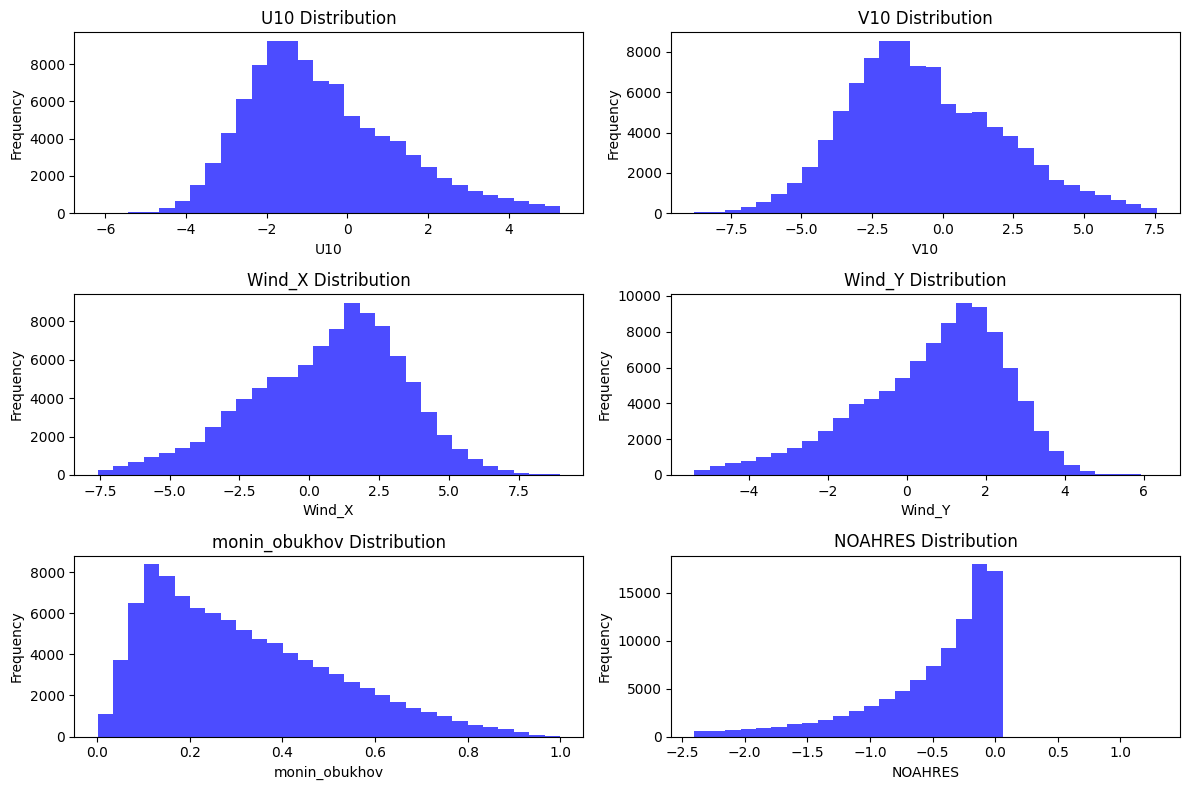

In [161]:
# 'U10' için histogramlar
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.hist(cleaned_data['U10'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('U10')
plt.ylabel('Frequency')
plt.title('U10 Distribution')

# 'V10' için histogramlar
plt.subplot(3, 2, 2)
plt.hist(cleaned_data['V10'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('V10')
plt.ylabel('Frequency')
plt.title('V10 Distribution')

# Wind_X için histogramlar
plt.subplot(3, 2, 3)
plt.hist(cleaned_data['Wind_X'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Wind_X')
plt.ylabel('Frequency')
plt.title('Wind_X Distribution')

# Wind_Y için histogramlar
plt.subplot(3, 2, 4)
plt.hist(cleaned_data['Wind_Y'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Wind_Y')
plt.ylabel('Frequency')
plt.title('Wind_Y Distribution')

# monin_obukhov için histogramlar
plt.subplot(3, 2, 5)
plt.hist(cleaned_data['monin_obukhov'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('monin_obukhov')
plt.ylabel('Frequency')
plt.title('monin_obukhov Distribution')

# NOAHRES için histogramlar
plt.subplot(3, 2, 6)
plt.hist(cleaned_data['NOAHRES'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('NOAHRES')
plt.ylabel('Frequency')
plt.title('NOAHRES Distribution')

plt.tight_layout()
plt.show()

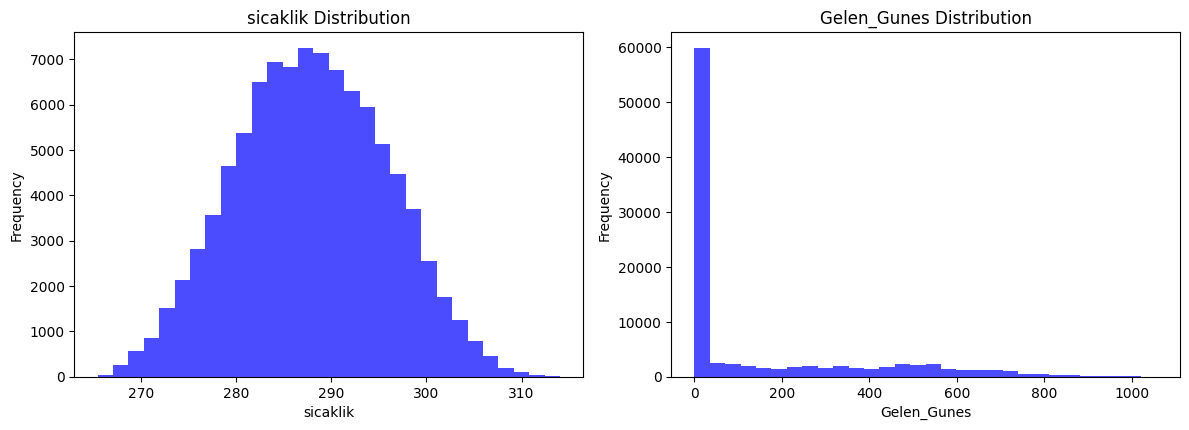

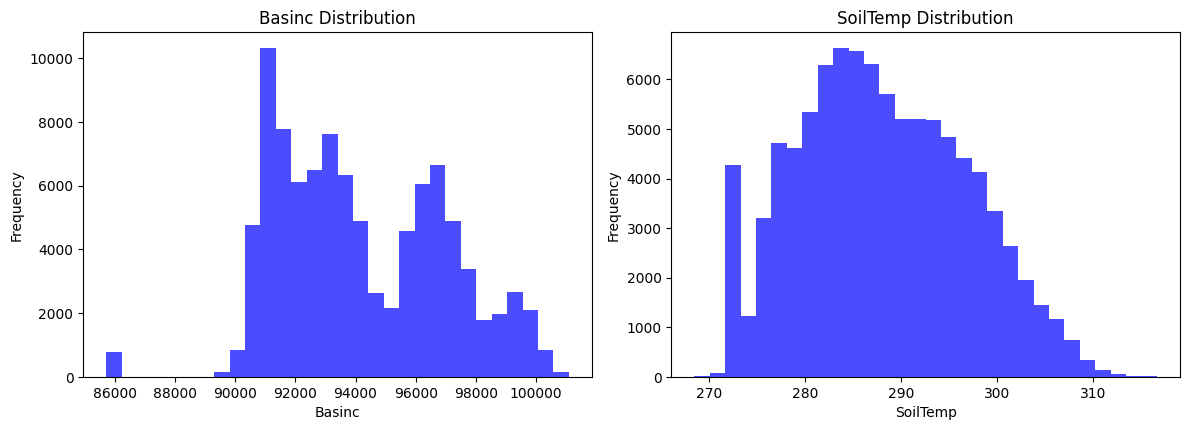

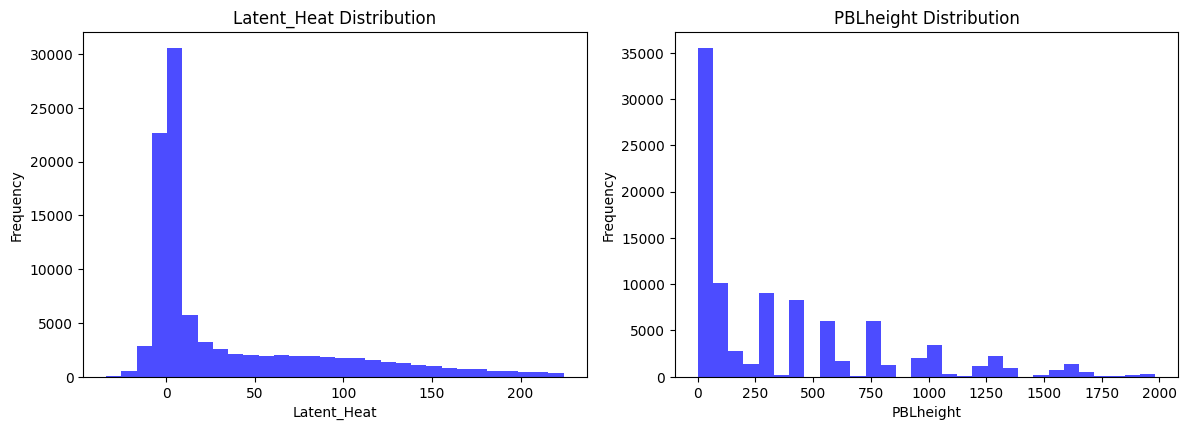

In [162]:
plt.figure(figsize=(12, 8))

# sicaklik için histogramlar
plt.subplot(2, 2, 1)
plt.hist(cleaned_data['sicaklik'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('sicaklik')
plt.ylabel('Frequency')
plt.title('sicaklik Distribution')

# Gelen_Gunes için histogramlar
plt.subplot(2, 2, 2)
plt.hist(cleaned_data['Gelen_Gunes'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Gelen_Gunes')
plt.ylabel('Frequency')
plt.title('Gelen_Gunes Distribution')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
# Basinc için histogramlar
plt.subplot(2, 2, 1)
plt.hist(cleaned_data['Basinc'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Basinc')
plt.ylabel('Frequency')
plt.title('Basinc Distribution')

# SoilTemp için histogramlar
plt.subplot(2, 2, 2)
plt.hist(cleaned_data['SoilTemp'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('SoilTemp')
plt.ylabel('Frequency')
plt.title('SoilTemp Distribution')


plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
# Latent_Heat için histogramlar
plt.subplot(2, 2, 1)
plt.hist(cleaned_data['Latent_Heat'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Latent_Heat')
plt.ylabel('Frequency')
plt.title('Latent_Heat Distribution')

# PBLheight için histogramlar
plt.subplot(2, 2, 2)
plt.hist(cleaned_data['PBLheight'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('PBLheight')
plt.ylabel('Frequency')
plt.title('PBLheight Distribution')


plt.tight_layout()
plt.show()


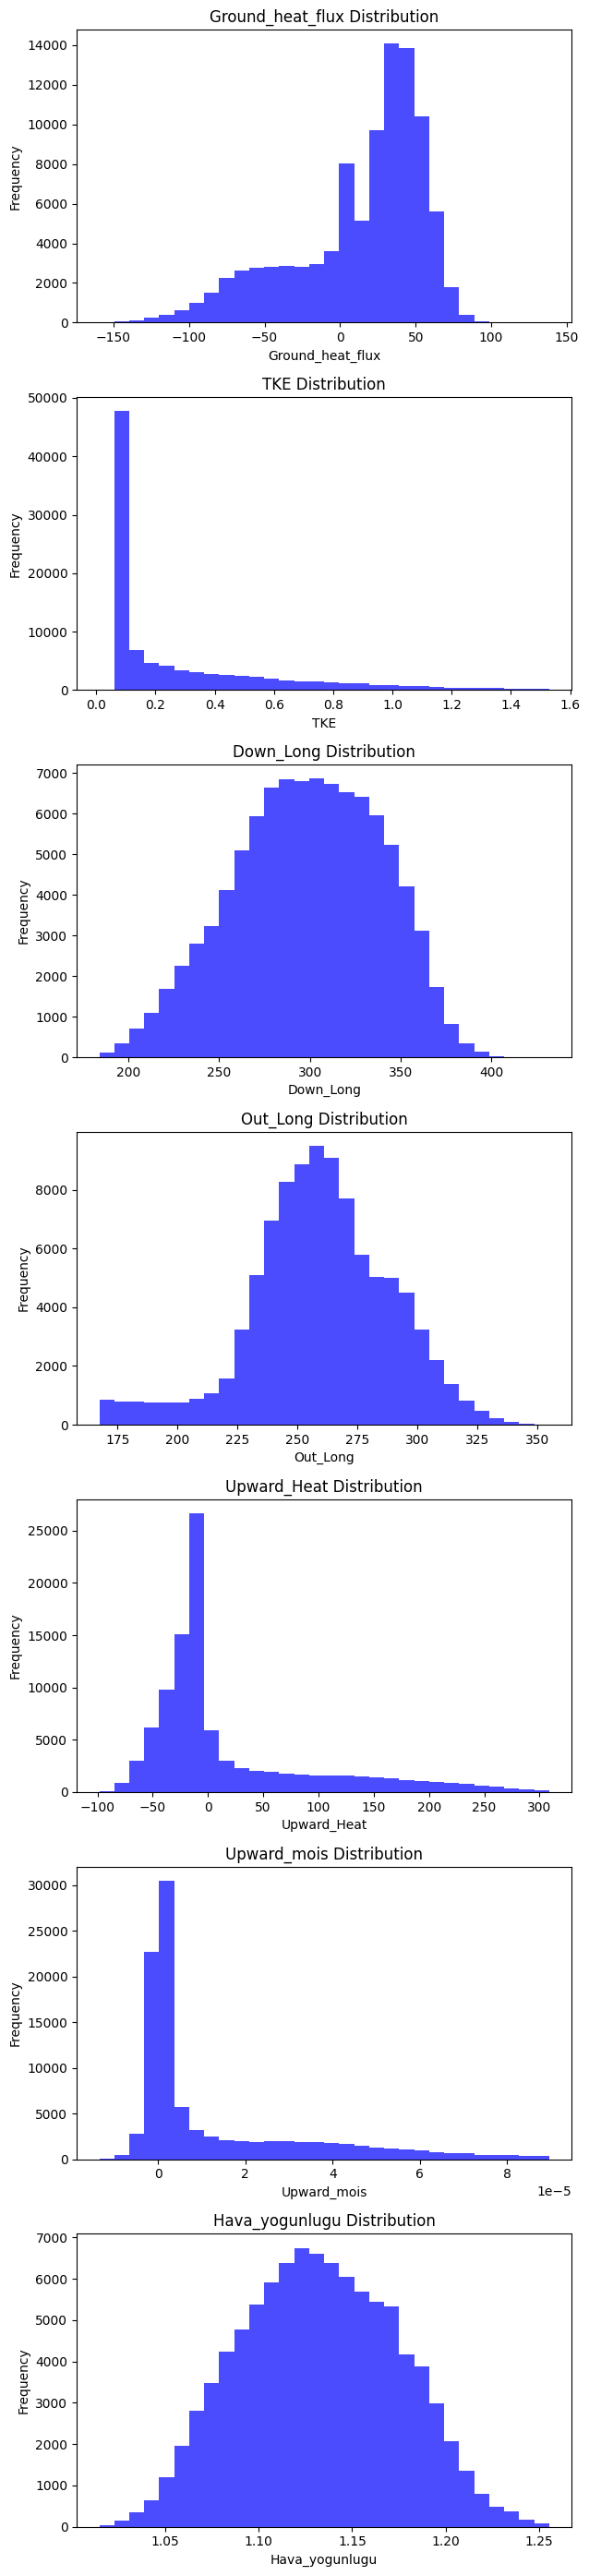

In [163]:

variables = ["Ground_heat_flux", "TKE", "Down_Long", "Out_Long", "Upward_Heat", "Upward_mois","Hava_yogunlugu"]

# Histogramlar
plt.figure(figsize=(12, 4 * len(variables)))

# Her bir değişken için aykırı değerleri temizle ve histogramları çiz
for i, variable in enumerate(variables, 1):
    # Orijinal veri için histogram
    plt.subplot(len(variables), 2, 2*i-1)
    plt.hist(cleaned_data[variable], bins=30, color='blue', alpha=0.7, label='Original Data')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'{variable} Distribution')
    
plt.tight_layout()
plt.show()


## Normalization

In [164]:
features_to_normalize = ["sicaklik", "U10", "V10", "Wind_X", "Wind_Y", "Basinc", "Gelen_Gunes", "Q2", "SoilTemp", "Ground_heat_flux", "TKE", "Down_Long", "Out_Long", "Upward_Heat", "Upward_mois","Hava_yogunlugu","Latent_Heat","PBLheight","monin_obukhov","NOAHRES"]
scaler = MinMaxScaler()
cleaned_data[features_to_normalize] = scaler.fit_transform(cleaned_data[features_to_normalize])

In [165]:
for feature in features_to_normalize:
    print(f"Statistics for {feature}:")
    print(f"Minimum: {cleaned_data[feature].min()}")
    print(f"Maximum: {cleaned_data[feature].max()}")
    print(f"Mean: {cleaned_data[feature].mean()}")
    print(f"Standard Deviation: {cleaned_data[feature].std()}")
    print("\n")

Statistics for sicaklik:
Minimum: 0.0
Maximum: 1.0
Mean: 0.46188935623029603
Standard Deviation: 0.16349963530662584


Statistics for U10:
Minimum: 0.0
Maximum: 1.0
Mean: 0.48362972213781674
Standard Deviation: 0.16177232093493032


Statistics for V10:
Minimum: 0.0
Maximum: 1.0
Mean: 0.4970252716121544
Standard Deviation: 0.16591856523694173


Statistics for Wind_X:
Minimum: 0.0
Maximum: 1.0
Mean: 0.49707851338930675
Standard Deviation: 0.164547212991938


Statistics for Wind_Y:
Minimum: 0.0
Maximum: 0.9999999999999999
Mean: 0.5150492406762117
Standard Deviation: 0.15905488066543355


Statistics for Basinc:
Minimum: 0.0
Maximum: 1.0
Mean: 0.5515288023262813
Standard Deviation: 0.18203724009165576


Statistics for Gelen_Gunes:
Minimum: 0.0
Maximum: 1.0
Mean: 0.13667558048787024
Standard Deviation: 0.21607211606800103


Statistics for Q2:
Minimum: 0.0
Maximum: 1.0
Mean: 0.4557996767568519
Standard Deviation: 0.19320698627179891


Statistics for SoilTemp:
Minimum: 0.0
Maximum: 1.0
Mean: 0

## Visualization

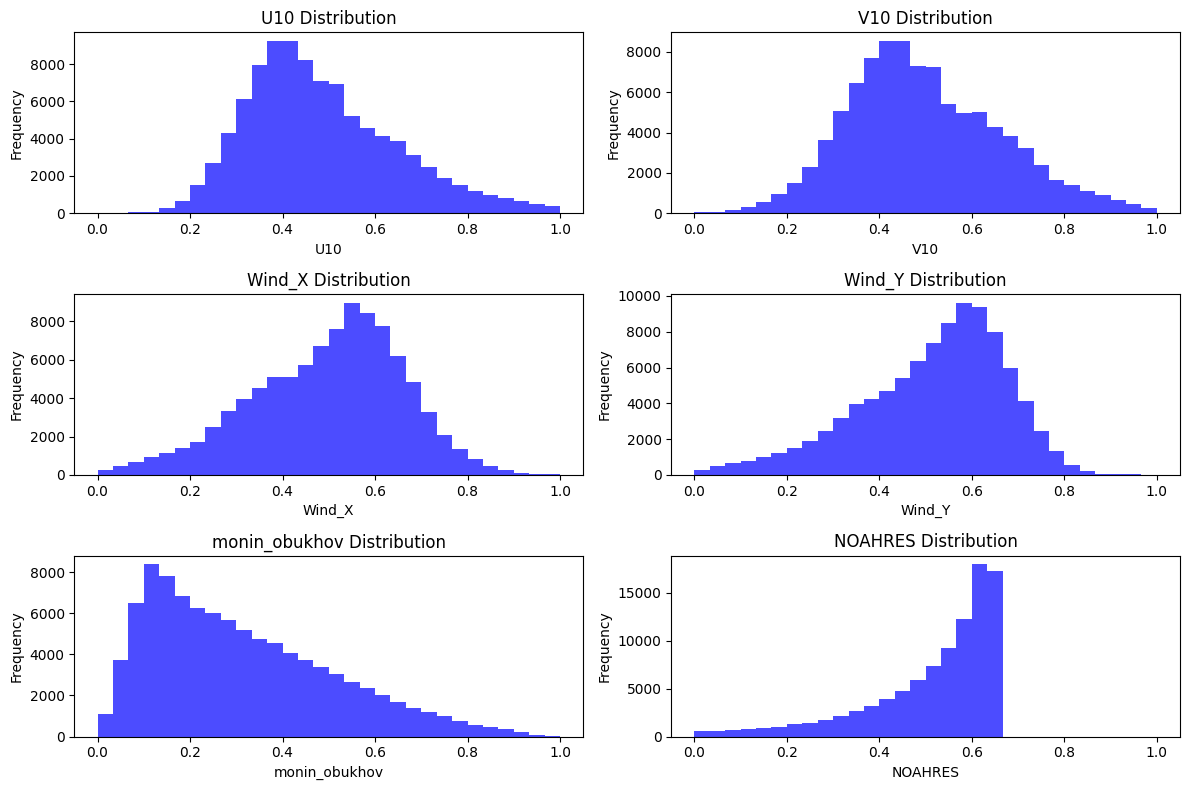

In [166]:
# 'U10' için histogramlar
plt.figure(figsize=(12, 8))
plt.subplot(3, 2, 1)
plt.hist(cleaned_data['U10'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('U10')
plt.ylabel('Frequency')
plt.title('U10 Distribution')

# 'V10' için histogramlar
plt.subplot(3, 2, 2)
plt.hist(cleaned_data['V10'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('V10')
plt.ylabel('Frequency')
plt.title('V10 Distribution')

# Wind_X için histogramlar
plt.subplot(3, 2, 3)
plt.hist(cleaned_data['Wind_X'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Wind_X')
plt.ylabel('Frequency')
plt.title('Wind_X Distribution')

# Wind_Y için histogramlar
plt.subplot(3, 2, 4)
plt.hist(cleaned_data['Wind_Y'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Wind_Y')
plt.ylabel('Frequency')
plt.title('Wind_Y Distribution')

# monin_obukhov için histogramlar
plt.subplot(3, 2, 5)
plt.hist(cleaned_data['monin_obukhov'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('monin_obukhov')
plt.ylabel('Frequency')
plt.title('monin_obukhov Distribution')

# NOAHRES için histogramlar
plt.subplot(3, 2, 6)
plt.hist(cleaned_data['NOAHRES'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('NOAHRES')
plt.ylabel('Frequency')
plt.title('NOAHRES Distribution')

plt.tight_layout()
plt.show()

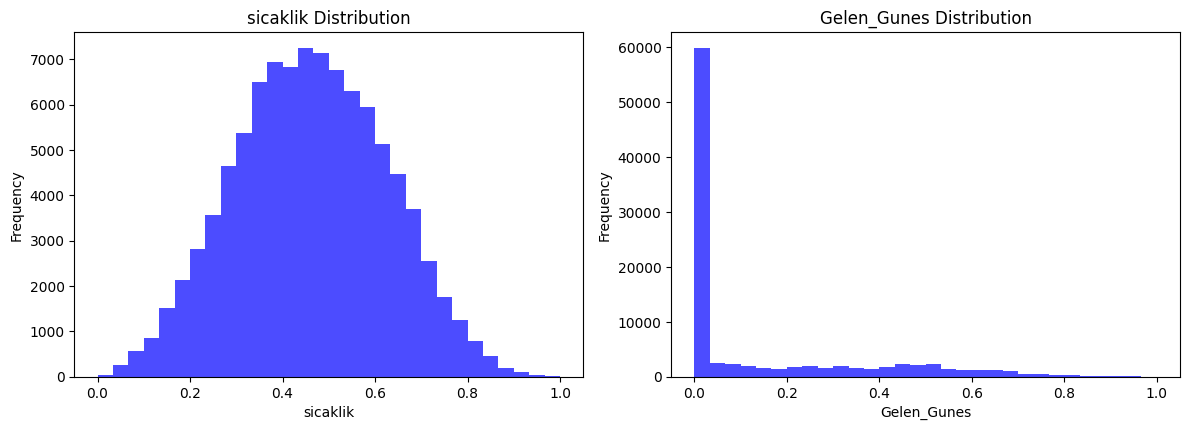

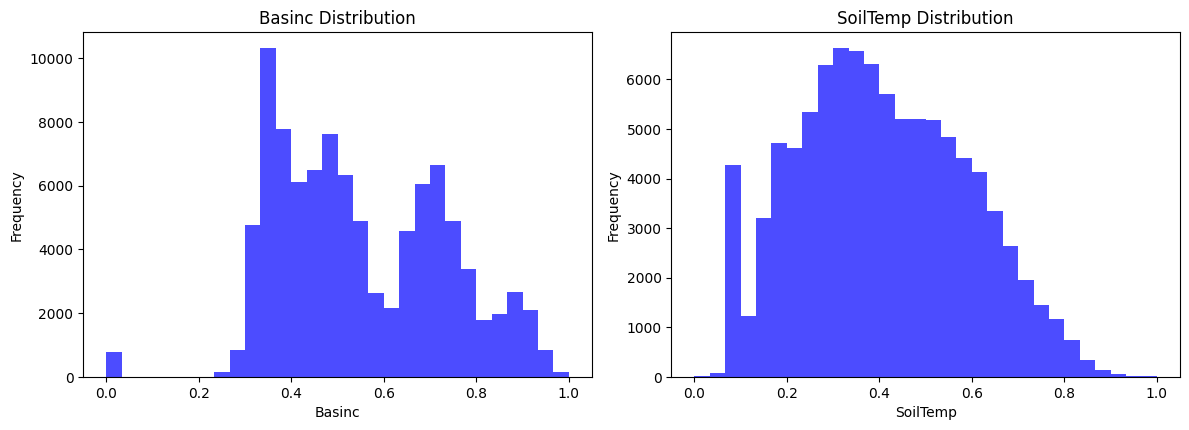

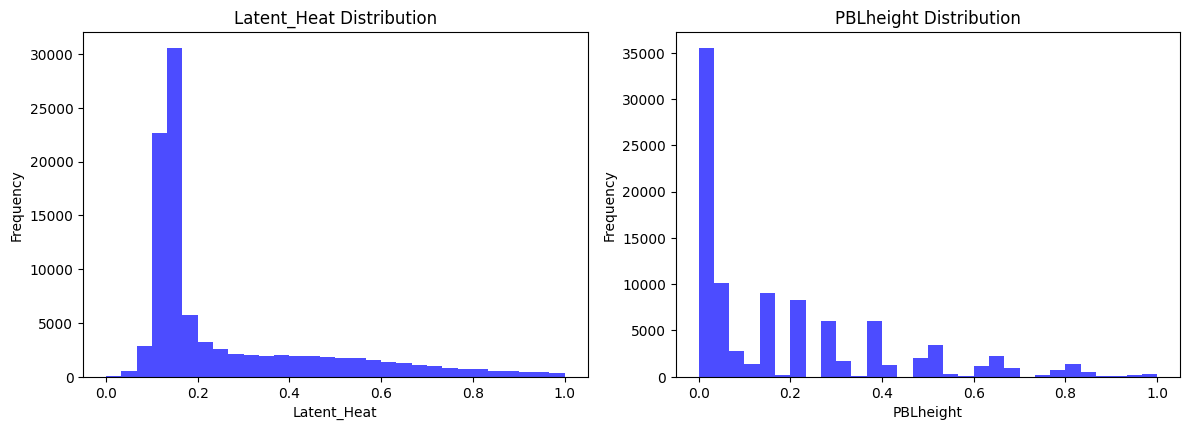

In [167]:
plt.figure(figsize=(12, 8))

# sicaklik için histogramlar
plt.subplot(2, 2, 1)
plt.hist(cleaned_data['sicaklik'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('sicaklik')
plt.ylabel('Frequency')
plt.title('sicaklik Distribution')

# Gelen_Gunes için histogramlar
plt.subplot(2, 2, 2)
plt.hist(cleaned_data['Gelen_Gunes'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Gelen_Gunes')
plt.ylabel('Frequency')
plt.title('Gelen_Gunes Distribution')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
# Basinc için histogramlar
plt.subplot(2, 2, 1)
plt.hist(cleaned_data['Basinc'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Basinc')
plt.ylabel('Frequency')
plt.title('Basinc Distribution')

# SoilTemp için histogramlar
plt.subplot(2, 2, 2)
plt.hist(cleaned_data['SoilTemp'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('SoilTemp')
plt.ylabel('Frequency')
plt.title('SoilTemp Distribution')


plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
# Latent_Heat için histogramlar
plt.subplot(2, 2, 1)
plt.hist(cleaned_data['Latent_Heat'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('Latent_Heat')
plt.ylabel('Frequency')
plt.title('Latent_Heat Distribution')

# PBLheight için histogramlar
plt.subplot(2, 2, 2)
plt.hist(cleaned_data['PBLheight'], bins=30, color='blue', alpha=0.7, label='Original Data')
plt.xlabel('PBLheight')
plt.ylabel('Frequency')
plt.title('PBLheight Distribution')


plt.tight_layout()
plt.show()

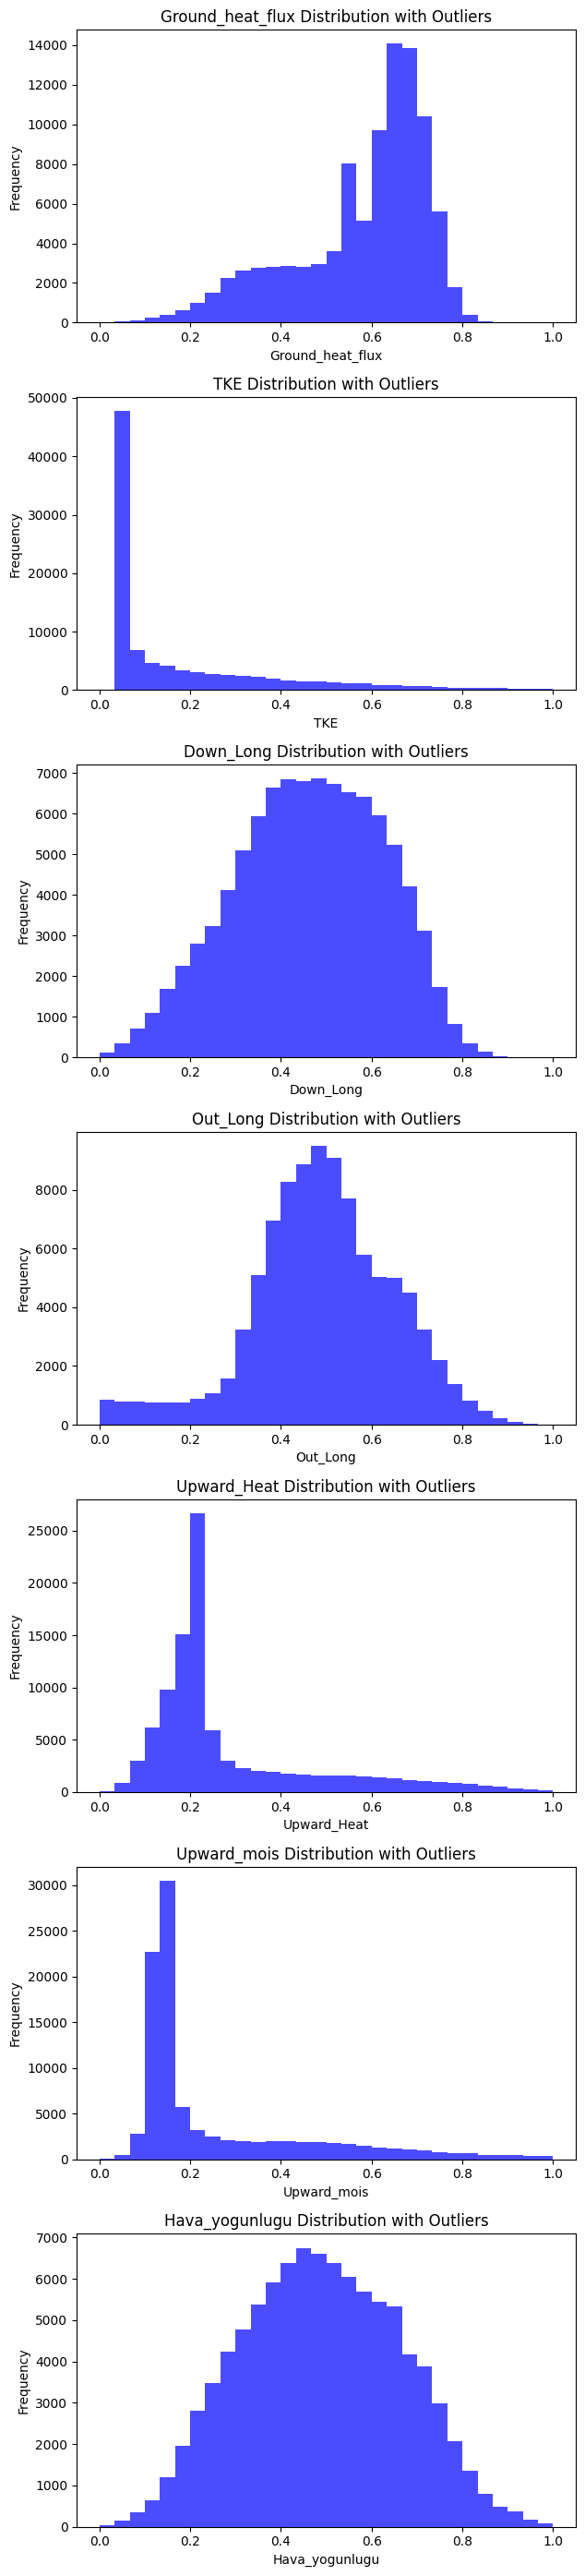

In [168]:
variables = ["Ground_heat_flux", "TKE", "Down_Long", "Out_Long", "Upward_Heat", "Upward_mois","Hava_yogunlugu"]

# Histogramlar
plt.figure(figsize=(12, 4 * len(variables)))

# Her bir değişken için aykırı değerleri temizle ve histogramları çiz
for i, variable in enumerate(variables, 1):
    # Orijinal veri için histogram
    plt.subplot(len(variables), 2, 2*i-1)
    plt.hist(cleaned_data[variable], bins=30, color='blue', alpha=0.7, label='Original Data')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'{variable} Distribution with Outliers')
    
plt.tight_layout()
plt.show()


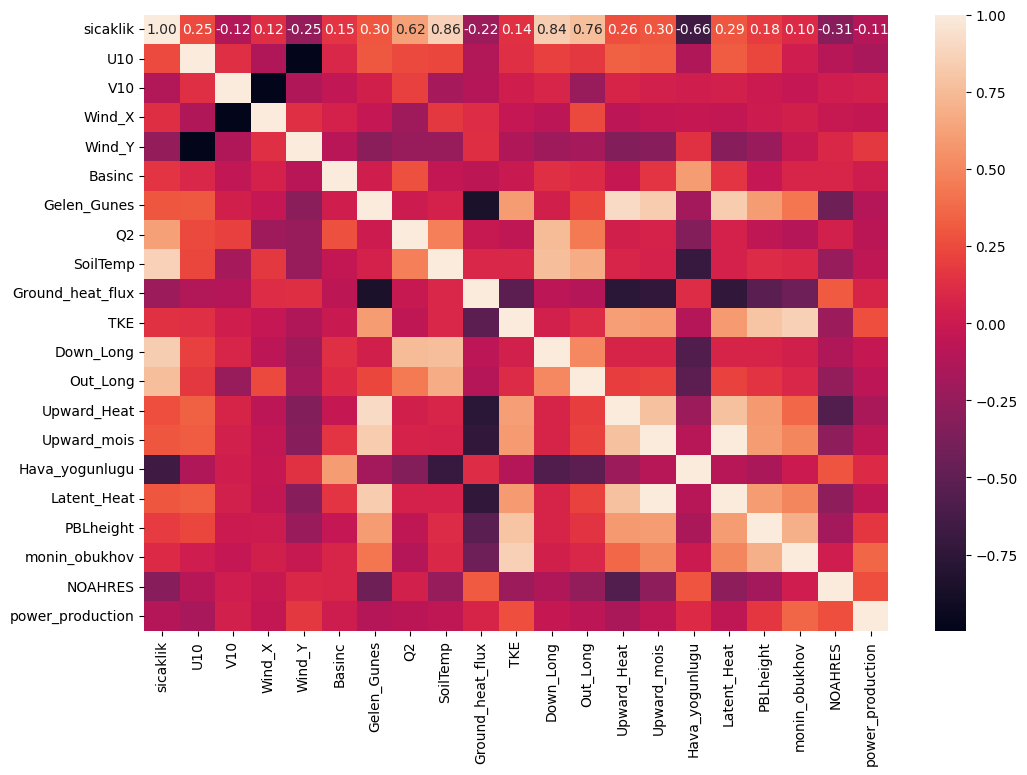

In [170]:
list1 = ["sicaklik", "U10", "V10", "Wind_X", "Wind_Y", "Basinc", "Gelen_Gunes", "Q2", "SoilTemp", "Ground_heat_flux", "TKE", "Down_Long", "Out_Long", "Upward_Heat", "Upward_mois", "Hava_yogunlugu", "Latent_Heat", "PBLheight", "monin_obukhov", "NOAHRES", "power_production"]

plt.figure(figsize=(12, 8))
sns.heatmap(cleaned_data[list1].corr(), annot=True, fmt=".2f")
plt.show()

In [148]:
cor_target = abs(cleaned_data[list1].corr()["power_production"])
relevant_features = cor_target[(cor_target > 0.1)]
relevant_features

sicaklik            0.110681
U10                 0.167319
Wind_Y              0.167783
Gelen_Gunes         0.113425
TKE                 0.264891
Upward_Heat         0.153331
Hava_yogunlugu      0.101931
PBLheight           0.164412
monin_obukhov       0.354052
NOAHRES             0.263157
power_production    1.000000
Name: power_production, dtype: float64

In [149]:
cor_target = abs(cleaned_data[list1].corr()["power_production"])
to_drop = cor_target[(cor_target < 0.1)]
to_drop

V10                 0.044142
Wind_X              0.043880
Basinc              0.014621
Q2                  0.083676
SoilTemp            0.058140
Ground_heat_flux    0.071411
Down_Long           0.029023
Out_Long            0.074105
Upward_mois         0.052899
Latent_Heat         0.052908
Name: power_production, dtype: float64

In [150]:
to_drop_frame = to_drop.to_frame()

In [151]:
to_drop_frame

,power_production
V10,0.044142
Wind_X,0.043880
Basinc,0.014621
Q2,0.083676
SoilTemp,0.058140
Ground_heat_flux,0.071411
Down_Long,0.029023
Out_Long,0.074105
Upward_mois,0.052899
Latent_Heat,0.052908


In [152]:
row_names = to_drop_frame.index
row_names_list = list(row_names)
row_names_list.append('power_production') # X ve y değişkenlerimi belirlerken X değişkeninden 'row_name_list' çıkarılacak

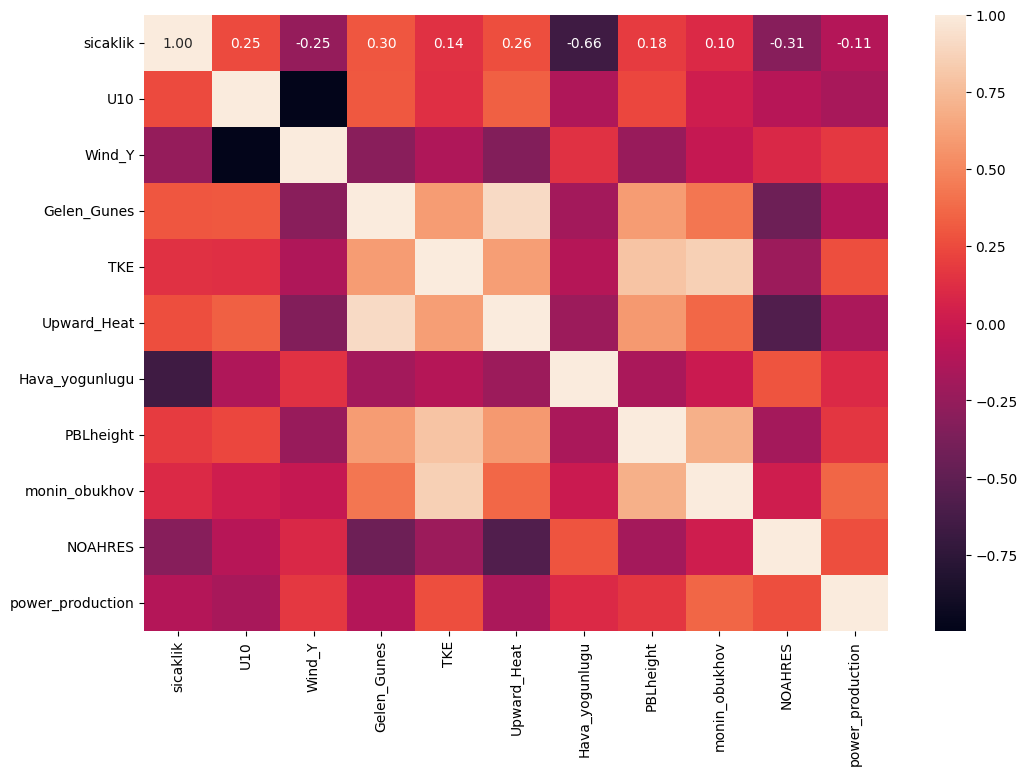

In [171]:
selected_features = cleaned_data[relevant_features.index]
correlation_matrix = selected_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot =True, fmt = ".2f")
plt.show()

## PCA

In [80]:
numerical_columns = cleaned_data.select_dtypes(include=['int', 'float']).columns
print(numerical_columns)
numerical_columns.shape

Index(['sicaklik', 'U10', 'V10', 'ruzgarhizi', 'ruzgaryonu', 'Basinc',
       'Gelen_Gunes', 'Q2', 'SoilTemp', 'Ground_heat_flux', 'TKE', 'Down_Long',
       'Out_Long', 'NOAHRES', 'Upward_Heat', 'Upward_mois', 'Latent_Heat',
       'PBLheight', '81m_U', '81m_V', '81m_W', '81m_U_V_ruzgar_hizi',
       '81m_U_V_W_ruzgar_hizi', '140m_U', '140m_V', '140m_W',
       '140m_U_V_ruzgar_hizi', '140m_U_V_W_ruzgar_hizi', 'seviye3_U',
       'seviye3_V', 'seviye3_W', 'seviye3_U_V_ruzgar_hizi',
       'seviye3_U_V_W_ruzgar_hizi', 'seviye4_U', 'seviye4_V', 'seviye4_W',
       'seviye4_U_V_ruzgar_hizi', 'seviye4_U_V_W_ruzgar_hizi', 'seviye5_U',
       'seviye5_V', 'seviye5_W', 'seviye5_U_V_ruzgar_hizi',
       'seviye5_U_V_W_ruzgar_hizi', '81m_U_destagger', '81m_V_destagger',
       '81m_W_destagger', '81m_U_V_ruzgar_hizi_destagger',
       '81m_U_V_W_ruzgar_hizi_destagger', '140m_U_destagger',
       '140m_V_destagger', '140m_W_destagger',
       '140m_U_V_ruzgar_hizi_destagger', '140m_U_V_W_ruzgar

(74,)

In [81]:
cleaned_data_without_date = cleaned_data.drop(['date','season'], axis=1)

In [82]:
X = cleaned_data_without_date.drop(row_names_list, axis=1)
y = cleaned_data['power_production']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
pca = PCA(n_components=53)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

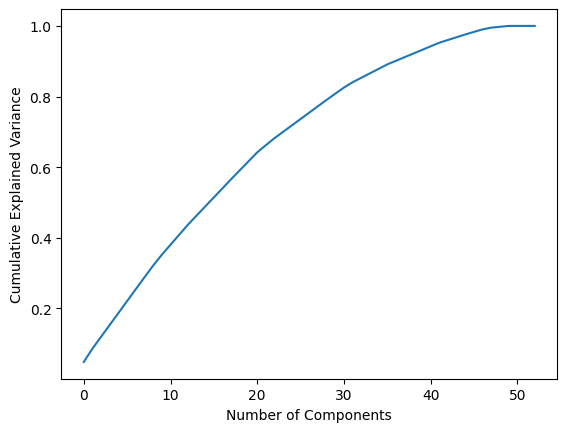

In [85]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [86]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 4.87),
 (2, 8.66),
 (3, 12.030000000000001),
 (4, 15.400000000000002),
 (5, 18.770000000000003),
 (6, 22.140000000000004),
 (7, 25.510000000000005),
 (8, 28.880000000000006),
 (9, 32.190000000000005),
 (10, 35.260000000000005),
 (11, 38.09),
 (12, 40.92),
 (13, 43.75),
 (14, 46.33),
 (15, 48.91),
 (16, 51.489999999999995),
 (17, 54.06999999999999),
 (18, 56.64999999999999),
 (19, 59.17999999999999),
 (20, 61.709999999999994),
 (21, 64.24),
 (22, 66.28),
 (23, 68.27),
 (24, 70.07),
 (25, 71.86999999999999),
 (26, 73.66999999999999),
 (27, 75.46999999999998),
 (28, 77.26999999999998),
 (29, 79.06999999999998),
 (30, 80.81999999999998),
 (31, 82.56999999999998),
 (32, 84.06999999999998),
 (33, 85.32999999999998),
 (34, 86.58999999999999),
 (35, 87.85),
 (36, 89.11),
 (37, 90.13),
 (38, 91.14999999999999),
 (39, 92.16999999999999),
 (40, 93.18999999999998),
 (41, 94.20999999999998),
 (42, 95.22999999999998),
 (43, 96.00999999999998),
 (44, 96.78999999999998),
 (45, 97.56999999999998),

## Modelling

### Random Forest Regressor

In [87]:
# Model pipeline'ları oluşturma
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [88]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

In [89]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42))
])

In [90]:
models = {'Linear Regression': pipeline_lr, 'Random Forest': pipeline_rf, 'XGBoost': pipeline_xgb}
results = {}

In [91]:
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    results[name] = {'MAE': mae, 'MAPE': mape}

In [92]:
for model in results:
    print(f"{model} - MAE: {results[model]['MAE']:.2f}, MAPE: {results[model]['MAPE']:.2f}")

Linear Regression - MAE: 17.19, MAPE: 6864314365516527.00
Random Forest - MAE: 8.63, MAPE: 2235629174670509.25
XGBoost - MAE: 9.08, MAPE: 2280790144097233.00


### Hypermeter Optimization with GridSearchCV

In [95]:
# En iyi modeli seçme ve hiperparametre ayarlama
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

In [96]:
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time= 2.0min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time= 2.0min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=50; total time= 2.0min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time= 4.0min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time= 4.0min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time= 4.0min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=50; total time= 1.9min
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=50; total time=

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'rf__max_depth': [None, 10],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error', verbose=2)

In [97]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
predictions_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, predictions_best)
mape_best = mean_absolute_percentage_error(y_test, predictions_best)
print(f"Optimized Random Forest - MAE: {mae_best:.2f}, MAPE: {mape_best:.2f}")

Best parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Optimized Random Forest - MAE: 8.63, MAPE: 2235629174670509.25


In [100]:
# Modelleri kaydetme
dump(pipeline_lr, 'linear_regression_model.joblib')
dump(pipeline_rf, 'random_forest_model.joblib')
dump(pipeline_xgb, 'xgboost_model.joblib')
dump(best_model, 'optimized_random_forest_model.joblib')

['optimized_random_forest_model.joblib']

In [101]:
# Model tahminleri
lr_predictions = pipeline_lr.predict(X_test)
rf_predictions = pipeline_rf.predict(X_test)
xgb_predictions = pipeline_xgb.predict(X_test)
optimized_rf_predictions = best_model.predict(X_test)

In [102]:
# Gerçek değerlerle birleştirme
predictions_df = pd.DataFrame({
    'Linear Regression': lr_predictions,
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'Optimized Random Forest': optimized_rf_predictions,
    'Actual': y_test
})

In [105]:
predictions_df.head(20)

,Linear Regression,Random Forest,XGBoost,Optimized Random Forest,Actual
398154,23.236210,10.1366,11.792992,10.1366,1.55
65246,27.348840,17.0999,14.228786,17.0999,0.00
407791,28.442785,51.6028,49.917217,51.6028,44.00
297445,13.038509,53.0869,63.087662,53.0869,59.00
57879,30.800340,52.0095,46.111092,52.0095,58.00
863589,25.916751,44.0645,30.435989,44.0645,58.00
748144,16.704689,8.7293,18.089258,8.7293,22.00
324245,21.438994,15.4382,9.807216,15.4382,4.50
550756,15.460794,9.5042,4.459470,9.5042,4.90
622955,2.198143,6.9685,2.474841,6.9685,3.63
